<a href="https://colab.research.google.com/github/raqueeb/nlp_bangla/blob/master/bangla_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install bnltk

In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

In [3]:
vocab_size = 1000
embedding_dim = 32
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 800

In [4]:
import json
with open('tech.json', encoding='utf-8') as f:
    datastore = json.load(f)
    
sentences = []
labels = []

for item in datastore:
    sentences.append(item['Text'])
    labels.append(item['Label'])

In [5]:
datastore[3]

{'Text': 'আপনি যদি নিয়মিত ফোনটি খুঁজছেন যা মোটামুটি টেকসই এটি দুর্দান্ত! বিশেষ করে ভারী ক্ষেত্রে ব্যবহার করা হয়? হ্যাঁ আমি এই ফোনটি সুপারিশ করব',
 'Reason': '',
 'Label': 'positive',
 'Source of Data': 'FP',
 'Date': '9/11/2020',
 'FIELD6': '',
 'FIELD7': '',
 'FIELD8': ''}

In [6]:
len(sentences)

2161

In [7]:
set(labels)

{'negative', 'neutral', 'positive'}

In [8]:
label_mapper = dict([(y,x) for x,y in enumerate(sorted(set(labels)))])
print(label_mapper)
label = np.array( [label_mapper[l] for l in labels] , dtype=np.float32)
print(label[0:5])

{'negative': 0, 'neutral': 1, 'positive': 2}
[2. 2. 0. 2. 2.]


In [9]:
# one hot encoded
cl_labels = np.zeros((len(label), len(set(labels))), dtype = np.float32)

for i in range(len(label)):
  cl_labels[ i, int(label[i]) ] = 1.

In [10]:
cl_labels[0]

array([0., 0., 1.], dtype=float32)

In [11]:
def read_stopwords(stopwords_file):
    stop_words = []
    with open(stopwords_file, encoding='utf-8-sig') as f:
        for line in f:
            stop_words.append(line.strip())
    return stop_words

In [12]:
stop_words = read_stopwords('stopwords-bn.txt')
stop_words

['অতএব',
 'অথচ',
 'অথবা',
 'অনুযায়ী',
 'অনেক',
 'অনেকে',
 'অনেকেই',
 'অন্তত',
 'অন্য',
 'অবধি',
 'অবশ্য',
 'অর্থাত',
 'আই',
 'আগামী',
 'আগে',
 'আগেই',
 'আছে',
 'আজ',
 'আদ্যভাগে',
 'আপনার',
 'আপনি',
 'আবার',
 'আমরা',
 'আমাকে',
 'আমাদের',
 'আমার',
 'আমি',
 'আর',
 'আরও',
 'ই',
 'ইত্যাদি',
 'ইহা',
 'উচিত',
 'উত্তর',
 'উনি',
 'উপর',
 'উপরে',
 'এ',
 'এঁদের',
 'এঁরা',
 'এই',
 'একই',
 'একটি',
 'একবার',
 'একে',
 'এক্',
 'এখন',
 'এখনও',
 'এখানে',
 'এখানেই',
 'এটা',
 'এটাই',
 'এটি',
 'এত',
 'এতটাই',
 'এতে',
 'এদের',
 'এব',
 'এবং',
 'এবার',
 'এমন',
 'এমনকী',
 'এমনি',
 'এর',
 'এরা',
 'এল',
 'এস',
 'এসে',
 'ঐ',
 'ও',
 'ওঁদের',
 'ওঁর',
 'ওঁরা',
 'ওই',
 'ওকে',
 'ওখানে',
 'ওদের',
 'ওর',
 'ওরা',
 'কখনও',
 'কত',
 'কবে',
 'কমনে',
 'কয়েক',
 'কয়েকটি',
 'করছে',
 'করছেন',
 'করতে',
 'করবে',
 'করবেন',
 'করলে',
 'করলেন',
 'করা',
 'করাই',
 'করায়',
 'করার',
 'করি',
 'করিতে',
 'করিয়া',
 'করিয়ে',
 'করে',
 'করেই',
 'করেছিলেন',
 'করেছে',
 'করেছেন',
 'করেন',
 'কাউকে',
 'কাছ',
 'কাছে',
 'কাজ',
 'কাজে',
 'কারও',
 '

In [13]:
sentences[3]

'আপনি যদি নিয়মিত ফোনটি খুঁজছেন যা মোটামুটি টেকসই এটি দুর্দান্ত! বিশেষ করে ভারী ক্ষেত্রে ব্যবহার করা হয়? হ্যাঁ আমি এই ফোনটি সুপারিশ করব'

In [14]:
#from bnltk.tokenize import Tokenizers
#t = Tokenizers()
#print(t.bn_word_tokenizer(sentences[1]))

In [15]:
from nltk import word_tokenize
words = []
for i in range(len(sentences)):
    words.append(word_tokenize(sentences[i]))
words[3]

['আপনি',
 'যদি',
 'নিয়মিত',
 'ফোনটি',
 'খুঁজছেন',
 'যা',
 'মোটামুটি',
 'টেকসই',
 'এটি',
 'দুর্দান্ত',
 '!',
 'বিশেষ',
 'করে',
 'ভারী',
 'ক্ষেত্রে',
 'ব্যবহার',
 'করা',
 'হয়',
 '?',
 'হ্যাঁ',
 'আমি',
 'এই',
 'ফোনটি',
 'সুপারিশ',
 'করব']

In [16]:
def remove_stopwords(word_list, stopwords_list):
    processed_word_list = []

    for doc in word_list:
        temp = []
        for word in doc:
            if word not in stopwords_list:
                temp.append(word)

        processed_word_list.append(temp)

    return processed_word_list

In [17]:
words = remove_stopwords(words,stop_words)
words[3]

['নিয়মিত',
 'ফোনটি',
 'খুঁজছেন',
 'মোটামুটি',
 'টেকসই',
 'দুর্দান্ত',
 'ভারী',
 'হ্যাঁ',
 'ফোনটি',
 'সুপারিশ',
 'করব']

In [18]:
#!pip install bangla-stemmer
stm = []
from bangla_stemmer.stemmer import stemmer
stmr = stemmer.BanglaStemmer()
for i in range(len(words)):
    stm.append(stmr.stem(words[i]))
stm[3]

applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules.

applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..

applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
a

applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied third rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
appli

applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
appl

applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
a

applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied

applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..


applied fourth rules..
applied third rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied

applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
appl

applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..


applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied third rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
appli

applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
app

applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
app

applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
ap

applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
appl

applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied third rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
appli

['নিয়মিত',
 'ফোন',
 'খুঁজছ',
 'মোটামু',
 'টেকস',
 'দুর্দান্ত',
 'ভারী',
 'হ্যাঁ',
 'ফোন',
 'সুপারিশ',
 'কর']

In [19]:
#from bnltk.stemmer import BanglaStemmer
#sdb = []
#bn_stemmer = BanglaStemmer()
#for i in range(len(words)):
 #   sdb.append(bn_stemmer.stem(words[i]))
#sdb[3]
#print(stmr.stem('গিয়েছে'))

In [20]:
#from bengali_stemmer.rafikamal2014 import RafiStemmer
#stemmer = RafiStemmer()
#stm = []
#for i in range(len(words)):
 #   stm.append(stemmer.stem_word(words[i]))
#stm[1]

In [21]:
training_sentences = stm[0:training_size]
testing_sentences = stm[training_size:]
training_labels = cl_labels[0:training_size]
testing_labels = cl_labels[training_size:]

In [22]:
len(testing_sentences)

1361

In [23]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'ভালো': 2,
 'মোবাইল': 3,
 'ফোন': 4,
 'মাউস': 5,
 'চার্জ': 6,
 'না।': 7,
 'মান': 8,
 'সাথে': 9,
 'ল্যাপটপ': 10,
 'দাম': 11,
 'পণ্য': 12,
 'সমস্যা': 13,
 'এক': 14,
 'হয়': 15,
 'কিন': 16,
 'কিবোর্ড': 17,
 'হেডফোন': 18,
 'ডেলিভারি': 19,
 'অর্ড': 20,
 'কম': 21,
 'চার্জার': 22,
 'কথা': 23,
 'দ্রুত': 24,
 'যায়': 25,
 'দিয়ে': 26,
 'ক্যাবল': 27,
 'দেয়': 28,
 'দুর্দান্ত': 29,
 'হাত': 30,
 'সুন্দর': 31,
 'খুব': 32,
 'কিনে': 33,
 'কীবোর্ড': 34,
 'ভাল': 35,
 'সময়': 36,
 'মোবাইলে': 37,
 'হওয়ায়': 38,
 'খারাপ': 39,
 'দেয়া': 40,
 'দারাজ': 41,
 'যায়।': 42,
 'টা': 43,
 'চমৎক': 44,
 'টাকা': 45,
 'প্রসেসর': 46,
 'ডেটা': 47,
 'ব্যাটারি': 48,
 'নষ্ট': 49,
 'সের': 50,
 'অসাধারণ': 51,
 'ব্লুটুথ': 52,
 'বাজারে': 53,
 'ছবি': 54,
 'বছর': 55,
 'আশা': 56,
 'মাইক্রোফোন': 57,
 'ক্যামে': 58,
 'নেই।': 59,
 'সত্যি': 60,
 'আইফোন': 61,
 'কেনা': 62,
 'আসলে': 63,
 'আসল': 64,
 'মাস': 65,
 'পাওয়': 66,
 'দেখ': 67,
 'পেল': 68,
 'বাটন': 69,
 'সাউন্ড': 70,
 'ছিল।': 71,
 'পাওয়া': 72,
 'দামে': 73,
 'ছিলো': 74,
 'কেন':

In [24]:
training_sentences[0]

['নকিয়া', 'ব্যাটারি', 'টা', 'ভালো']

In [25]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_sequences[0]

print(len(training_sequences[0]))
print(len(training_padded[0]))

print(len(training_sequences[1]))
print(len(training_padded[1]))

print(len(training_sequences[10]))
print(len(training_padded[10]))

4
120
5
120
14
120


In [26]:
training_sequences[0]

[864, 48, 43, 2]

In [27]:
training_padded[0]

array([864,  48,  43,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

In [28]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(testing_sequences))
print(testing_padded.shape)

1361
(1361, 120)


In [29]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [30]:
training_padded[0]

array([864,  48,  43,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

In [31]:
testing_padded[0]

array([137,   1, 504,  72,   4,  81,  21,  73,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

In [32]:
training_padded

array([[864,  48,  43, ...,   0,   0,   0],
       [103, 529,  58, ...,   0,   0,   0],
       [865, 159, 866, ...,   0,   0,   0],
       ...,
       [285,  39,   3, ...,   0,   0,   0],
       [  3,   1, 752, ...,   0,   0,   0],
       [861, 215,   4, ...,   0,   0,   0]])

In [33]:
testing_padded

array([[137,   1, 504, ...,   0,   0,   0],
       [  5, 579, 579, ...,   0,   0,   0],
       [  5,  20,  74, ...,   0,   0,   0],
       ...,
       [672,   3,  48, ...,   0,   0,   0],
       [ 30,   1,   1, ...,   0,   0,   0],
       [  3,   1, 972, ...,   0,   0,   0]])

In [34]:
# model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dense(9, activation='softmax')
#])

model =  tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                              tf.keras.layers.Dense(3,  activation='softmax')
])

In [35]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 256)          164864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 591,875
Trainable params: 591,875
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epochs = 4
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/4
25/25 - 11s - loss: 0.9458 - accuracy: 0.5125 - val_loss: 0.7871 - val_accuracy: 0.5040
Epoch 2/4
25/25 - 9s - loss: 0.8987 - accuracy: 0.5362 - val_loss: 0.8259 - val_accuracy: 0.5040
Epoch 3/4
25/25 - 10s - loss: 0.7930 - accuracy: 0.6687 - val_loss: 0.7949 - val_accuracy: 0.6591
Epoch 4/4
25/25 - 9s - loss: 0.5750 - accuracy: 0.7887 - val_loss: 0.7874 - val_accuracy: 0.7002


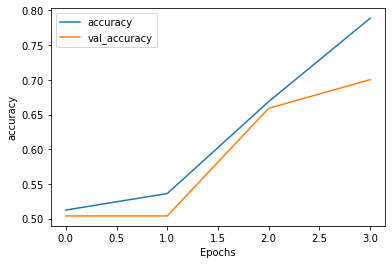

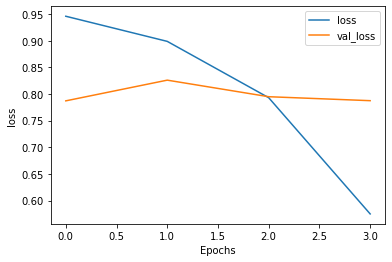

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [39]:
sentence = ["জায়গাটা অনেক অপরিষ্কার"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.5669899  0.137816   0.29519412]]


In [40]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 

(1000, 32)


In [41]:
y_pred = model.predict_classes(testing_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [42]:
y_pred[40]

0

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(testing_labels, y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
#from sklearn.metrics import confusion_matrix

In [ ]:
#confusion_matrix(testing_padded,y_pred)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(cl_labels,y_pred)